In [59]:
import torch
from torchvision import transforms
import torchvision
from PIL import Image
from models import FaceNetModel
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from random import sample, choice
import json
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import pandas as pd
from models import model_921, model_920
from eval_metrics import evaluate, plot_roc

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
root = '/home/khairulimam/datasets/lfw-mtcnn-182/'
df = pd.read_csv('datasets/lfw-mtcnn-182.csv')
classes = df['class'].unique()
class_row_counts = df['class'].value_counts()
images_above1_index = class_row_counts[class_row_counts > 2].index.tolist()
images_above1 = df[df['class'].isin(images_above1_index)]

In [7]:
model = model_920()
model.to(device)
model = torch.nn.DataParallel(model)

Downloading: "https://github.com/khrlimam/facenet/releases/download/acc-0.920/model920-6be7e3e9.pth" to /home/khairulimam/.cache/torch/checkpoints/model920-6be7e3e9.pth
100%|██████████| 145983892/145983892 [02:52<00:00, 844705.10it/s] 


In [8]:
trfrm = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
topil = transforms.ToPILImage()
totensor = transforms.Compose(trfrm.transforms[:-1])

In [9]:
def get_same_notsame(size):
    notsame = []
    same = []
    while len(same) < size:
        class_ = images_above1.sample().iloc[0]['class']
        same_pairs = images_above1[images_above1['class'] == class_].sample(2)
        same.append((same_pairs.iloc[0], same_pairs.iloc[1]))
    while len(notsame) < size:
        pair1 = images_above1.sample()
        pair2 = images_above1[images_above1['class'] != pair1.iloc[0]['class']].sample()
        notsame.append((pair1.iloc[0], pair2.iloc[0]))
    return {'same': same, 'notsame': notsame}

def get_random_pairs(size):
    pairs = []
    while len(pairs) < size:
        must_same = choice([True, False])
        if must_same:
            class_ = images_above1.sample().iloc[0]['class']
            same_pairs = images_above1[images_above1['class'] == class_].sample(2)
            pairs.append((same_pairs.iloc[0], same_pairs.iloc[1]))
        else:
            pair1 = images_above1.sample()
            pair2 = images_above1[images_above1['class'] != pair1.iloc[0]['class']].sample()
            pairs.append((pair1.iloc[0], pair2.iloc[0]))
    return pairs
    
def imshow(img,text=None,should_save=False):
    npimg = torchvision.utils.make_grid(img).numpy()
    plt.axis("off")
    if text:
        plt.text(220, 243, text, fontweight='bold', horizontalalignment='center',
            bbox=dict(facecolor='white', alpha=0.8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def get_distance(timg1, timg2):
    model.eval()
    with torch.no_grad():
        embed1 = model(timg1.unsqueeze(0))
        embed2 = model(timg2.unsqueeze(0))
    return F.pairwise_distance(embed1, embed2).item()

def get_path(root, item):
    return os.path.join(root, item['name'], item['id'] + "."+item['ext'])

In [10]:
random_pairs = get_random_pairs(30)

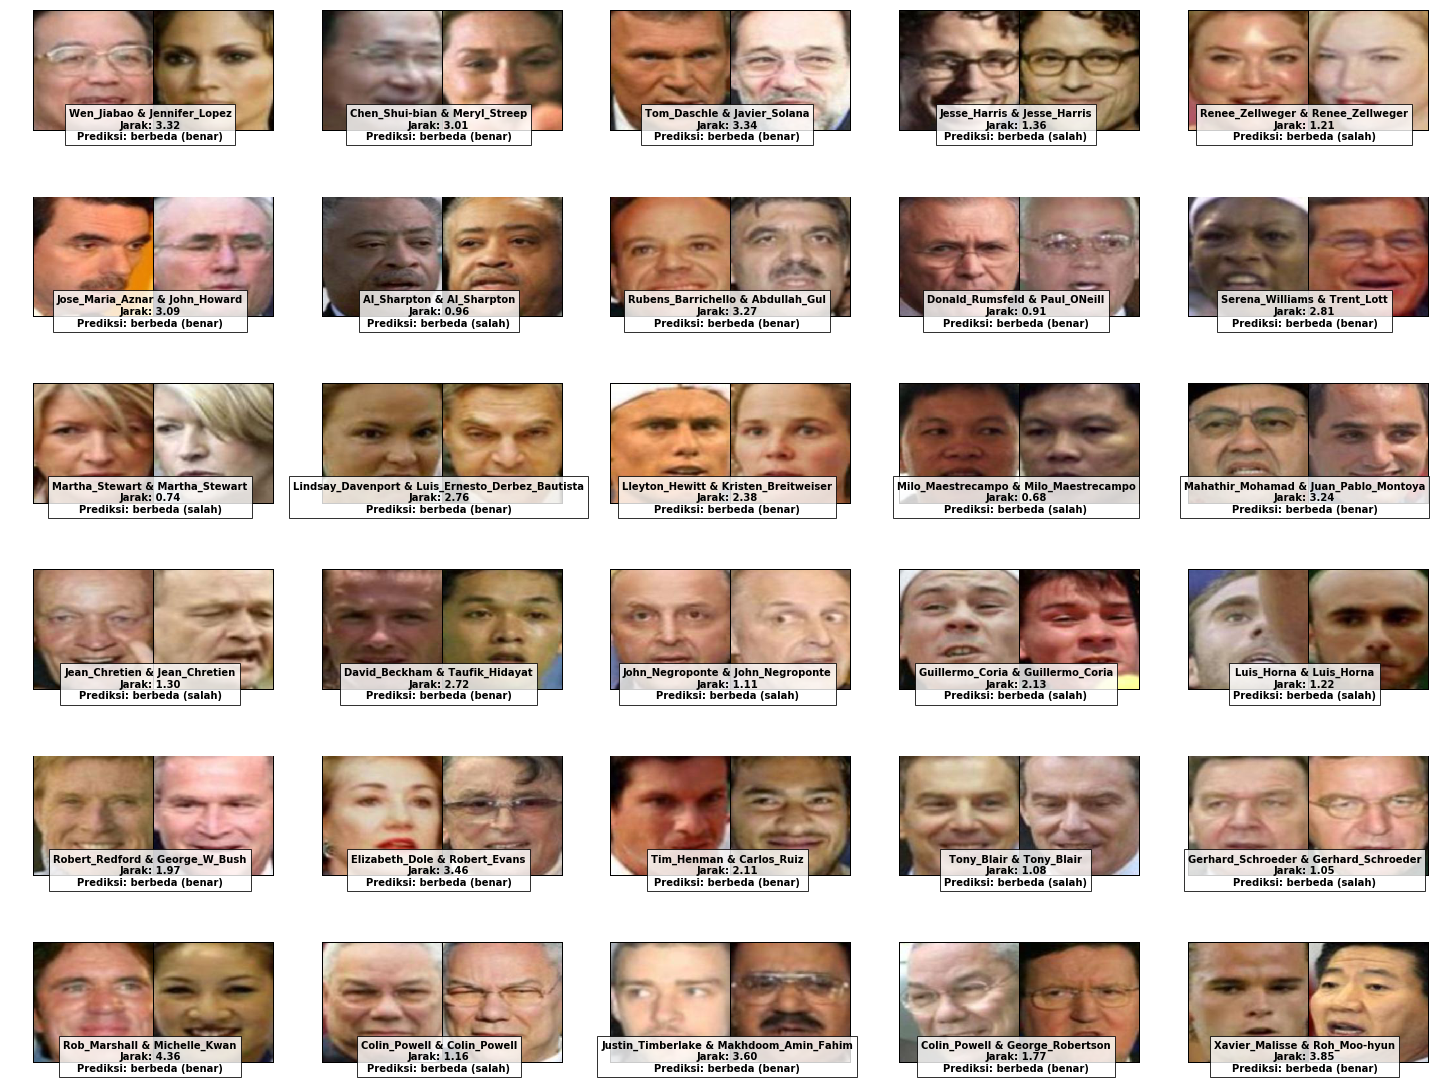

In [11]:
result = []
threshold = .6
plt.figure(figsize=(25, 20))
os.makedirs("random/"+str(threshold), exist_ok=True)
model.eval()
with torch.no_grad():
    for num, item in enumerate(random_pairs, 1):
        a,b = map(lambda i: trfrm(Image.open(get_path(root, i))).unsqueeze(0).to(device), item)
        x0, x1 = map(lambda i: totensor(Image.open(get_path(root, i))).unsqueeze(0), item)
        embed1, embed2 = model(a), model(b)
        concatenated = torch.cat((x0,x1),0)
        euclidean_distance = F.pairwise_distance(embed1, embed2)
        name1, name2 = item[0]['name'], item[1]['name']
        not_same = euclidean_distance > threshold
        diff_class = int(item[0]['class'] != item[1]['class'])
        pred = ("sama", "berbeda")[not_same]
        actual = ("salah", "benar")[diff_class == not_same]
        greater = ("≤", ">")[not_same]
        text = f"{name1} & {name2}\nJarak: {euclidean_distance.item():.2f}\nPrediksi: {pred} ({actual})"
        plt.subplot(6,5,num)
        imshow(concatenated, text)
plt.show()

In [16]:
result = defaultdict(list)
# plt.figure(figsize=(25, 15))
model.eval()
with torch.no_grad():
    for threshold in np.arange(0.5, 5, 0.1):
        os.makedirs("random/"+str(threshold), exist_ok=True)
        for num, item in enumerate(random_pairs, 1):
            a,b = map(lambda i: trfrm(Image.open(get_path(root, i))).unsqueeze(0).to(device), item)
            x0, x1 = map(lambda i: totensor(Image.open(get_path(root, i))).unsqueeze(0), item)
            embed1, embed2 = model(a), model(b)
            concatenated = torch.cat((x0,x1),0)
            euclidean_distance = F.pairwise_distance(embed1, embed2)
            name1, name2 = item[0]['name'], item[1]['name']
            not_same = euclidean_distance > threshold
            diff_class = int(item[0]['class'] != item[1]['class'])
            pred = ("sama", "berbeda")[not_same]
            actual = ("salah", "benar")[diff_class == not_same]
            result[threshold].append((diff_class == not_same).item())
            text = f"{name1} & {name2}\nJarak: {euclidean_distance.item():.2f}\nPrediksi: {pred} ({actual})"
#         plt.subplot(5,5,num)
#             imshow(concatenated, text)
#             plt.savefig("random/"+str(threshold)+"/random"+str(num)+".png")
#             plt.show()
# plt.show()

In [17]:
x = result.keys()
y = [sum(i) for i in result.values()]

In [50]:
from texttable import Texttable

In [60]:
table = Texttable()
table.add_row(['Threshold', 'Counts'])
for thres, count in zip(x,y):
    table.add_row([round(thres, 1), count])
print(table.draw())

+-----------+--------+
| Threshold | Counts |
+-----------+--------+
| 0.500     | 18     |
+-----------+--------+
| 0.600     | 18     |
+-----------+--------+
| 0.700     | 19     |
+-----------+--------+
| 0.800     | 20     |
+-----------+--------+
| 0.900     | 20     |
+-----------+--------+
| 1         | 20     |
+-----------+--------+
| 1.100     | 22     |
+-----------+--------+
| 1.200     | 24     |
+-----------+--------+
| 1.300     | 27     |
+-----------+--------+
| 1.400     | 28     |
+-----------+--------+
| 1.500     | 28     |
+-----------+--------+
| 1.600     | 28     |
+-----------+--------+
| 1.700     | 28     |
+-----------+--------+
| 1.800     | 27     |
+-----------+--------+
| 1.900     | 27     |
+-----------+--------+
| 2         | 26     |
+-----------+--------+
| 2.100     | 26     |
+-----------+--------+
| 2.200     | 26     |
+-----------+--------+
| 2.300     | 26     |
+-----------+--------+
| 2.400     | 25     |
+-----------+--------+
| 2.500    

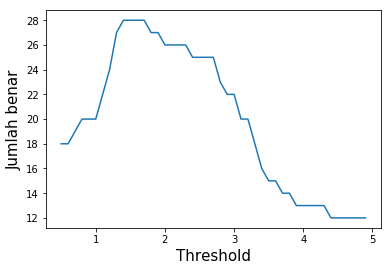

In [43]:
plt.xlabel('Threshold', fontsize=15)
plt.ylabel('Jumlah benar', fontsize=15)
plt.plot(x,y)
plt.savefig('threshold.png')

In [20]:
from data_loader import get_dataloader

In [55]:
data_loaders, data_size = get_dataloader('/home/khairulimam/datasets/lfw-mtcnn-182/', '/home/khairulimam/datasets/lfw-mtcnn-182/',
                                                 'datasets/lfw-mtcnn-182.csv', 'datasets/lfw-mtcnn-182.csv',
                                                 10000, 10000,
                                                 16, 8)

In [56]:
valid = data_loaders['valid']

Accuracy           = 0.91160000


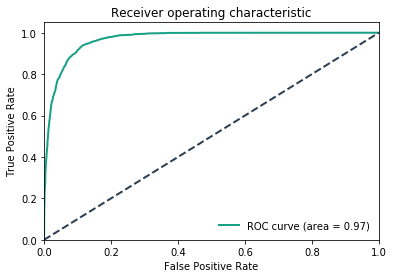

In [57]:
model.eval()
labels, distances = [], []
for batch_idx, batch_sample in enumerate(valid):
    anc_img = batch_sample['anc_img'].to(device)
    pos_img = batch_sample['pos_img'].to(device)
    neg_img = batch_sample['neg_img'].to(device)
    
    anc_embed, pos_embed, neg_embed = model(anc_img), model(pos_img), model(neg_img)
    
    pos_dist = F.pairwise_distance(anc_embed, pos_embed)
    neg_dist = F.pairwise_distance(anc_embed, neg_embed)
    
    distances.append(pos_dist.data.cpu().numpy())
    labels.append(np.ones(pos_dist.size(0)))
    
    distances.append(neg_dist.data.cpu().numpy())
    labels.append(np.zeros(neg_dist.size(0)))

labels = np.array([sublabel for label in labels for sublabel in label])
distances = np.array([subdist for dist in distances for subdist in dist])

tpr, fpr, accuracy, val, val_std, far = evaluate(distances, labels)
print('Accuracy           = {:.8f}'.format(np.mean(accuracy)))
plot_roc(fpr, tpr, figure_name='roc.png')

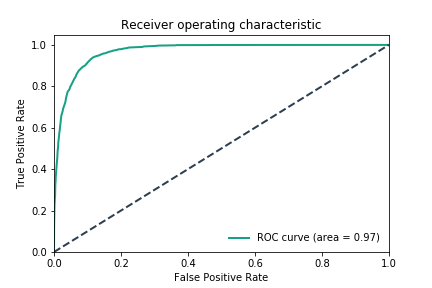

In [58]:
Image.open('roc.png')